# Tunning Reg CInc - For CInc

## Importing Libraries

In [12]:
import pandas as pd
rs = 42
import numpy as np
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from scipy.stats import loguniform as sp_loguniform
from sklearn.model_selection import KFold,StratifiedKFold
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV, RidgeCV ,Lasso, Ridge, ElasticNet, LogisticRegression, LogisticRegression
from sklearn.dummy import DummyClassifier, DummyRegressor
from lightgbm import LGBMRegressor
rs = 42
from  rfpimp import plot_corr_heatmap, feature_corr_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import  accuracy_score,make_scorer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.pipeline import Pipeline
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import mlxtend
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn import metrics
from numpy import arange
#pip install scikit-plot
from sklearn.metrics import confusion_matrix
#import scikitplot as skplt

from sklearn.feature_selection import RFECV, RFE
from sklearn.model_selection import cross_val_score
from numpy import mean, std
import seaborn as sns

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns


from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
# created functions
from evaluation import cross_validation_report_reg, nulls, boxplot_metrics, time_bar_chart, test_validation_bin,test_validation_reg

In [13]:
#!pip install rfpimp


In [15]:
# importing dataset
dataset_l_tr = pd.read_csv('../Preprocessing/preprocess_files/df_tr_l.csv')
dataset_l_ho = pd.read_csv('../Preprocessing/preprocess_files/df_ho_l.csv')
dataset_l_tr.drop(['Donates','Volunteers'], axis = 1, inplace = True)
dataset_l_ho.drop(['Donates','Volunteers'], axis = 1, inplace = True)

In [16]:
# split the data into X and Y
y_ltr_r = dataset_l_tr['CInc'].copy()
X_ltr = dataset_l_tr.drop(['CInc','quant'],axis=1).copy()

y_lho_r = dataset_l_ho['CInc'].copy()
X_lho = dataset_l_ho.drop(['CInc','quant'],axis=1).copy()


In [17]:
cv = StratifiedKFold(n_splits=10, random_state=rs, shuffle = True)

In [18]:
dataset_l_tr.Planning_Imp.value_counts()

3.0    6797
2.0    4970
1.0    2532
Name: Planning_Imp, dtype: int64

## Models

### Random Forest Tunning

In [6]:
est = RandomForestRegressor(n_jobs = -1, random_state = rs,criterion = 'mse')
rfe = RFE(est, n_features_to_select=  20)
rfe.fit(X_ltr, y_ltr_r)
selected_feat_rf = []
for i in range(X_ltr.shape[1]):
    print('Column: %s, Selected %s, Rank: %.3f' % (X_ltr.columns[i], rfe.support_[i], rfe.ranking_[i]))
    if rfe.support_[i] == True: 
        selected_feat_rf.append(X_ltr.columns[i]) 

Column: Bachelor_GPA, Selected True, Rank: 1.000
Column: Bachelor_Honors, Selected False, Rank: 45.000
Column: Age, Selected True, Rank: 1.000
Column: Gender, Selected True, Rank: 1.000
Column: Scholarship_Percent, Selected True, Rank: 1.000
Column: First_Comp_Size, Selected True, Rank: 1.000
Column: Curr_Comp_Size, Selected True, Rank: 1.000
Column: Country_First_Job, Selected False, Rank: 20.000
Column: Years_Worked_Foreign, Selected True, Rank: 1.000
Column: Senior_Position, Selected True, Rank: 1.000
Column: People_in_Charge, Selected True, Rank: 1.000
Column: Negotiation_Imp, Selected True, Rank: 1.000
Column: TeamWork_Imp, Selected True, Rank: 1.000
Column: Innovation_Imp, Selected True, Rank: 1.000
Column: Communication_Imp, Selected True, Rank: 1.000
Column: Planning_Imp, Selected True, Rank: 1.000
Column: No_Created_Ventures, Selected True, Rank: 1.000
Column: Used_Incubator_program, Selected False, Rank: 52.000
Column: Board_Member, Selected True, Rank: 1.000
Column: NonProfi

In [8]:
selected_feat_rf

['Bachelor_GPA',
 'Age',
 'Gender',
 'Scholarship_Percent',
 'First_Comp_Size',
 'Curr_Comp_Size',
 'Years_Worked_Foreign',
 'Senior_Position',
 'People_in_Charge',
 'Negotiation_Imp',
 'TeamWork_Imp',
 'Innovation_Imp',
 'Communication_Imp',
 'Planning_Imp',
 'No_Created_Ventures',
 'Board_Member',
 'Curr_Loc_Foreign',
 'CurrE_Senior Manager',
 'FInc',
 'work_hours_week']

In [19]:
selected_feat_rf = ['Bachelor_GPA',
 'Age',
 'Gender',
 'Scholarship_Percent',
 'First_Comp_Size',
 'Curr_Comp_Size',
 'Years_Worked_Foreign',
 'Senior_Position',
 'People_in_Charge',
 'Negotiation_Imp',
 'TeamWork_Imp',
 'Innovation_Imp',
 'Communication_Imp',
 'Planning_Imp',
 'No_Created_Ventures',
 'Board_Member',
 'Curr_Loc_Foreign',
 'CurrE_Senior Manager',
 'FInc',
 'work_hours_week']

In [20]:
def get_models():
    models = dict()
    for i in range(2, 21):
        rfe = RFE(estimator=est, n_features_to_select=i)
        models[str(i)] = Pipeline(steps=[('s',rfe),('m',est)])
    return models
def evaluate_model(model, X, y):
    cv = StratifiedKFold(n_splits=5, random_state=rs)
    scores = -cross_val_score(model,X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    return scores

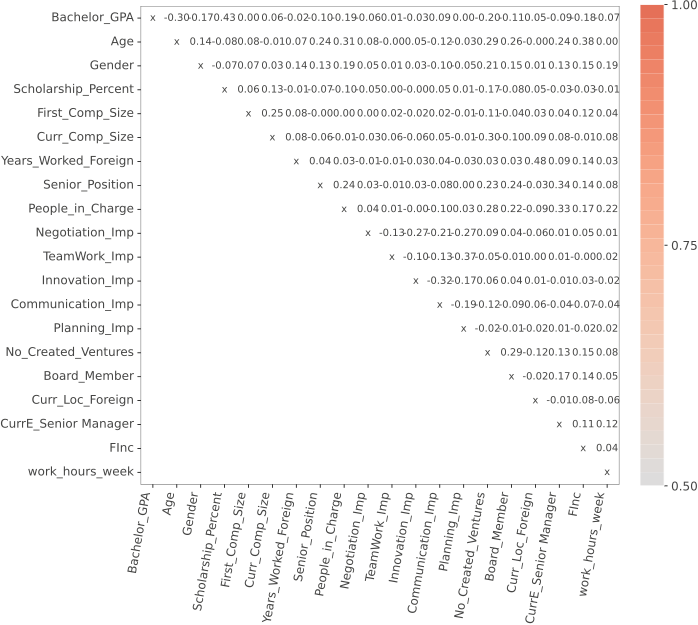

In [24]:
# Correlation Heatmap

viz = plot_corr_heatmap(X_ltr[selected_feat_rf],figsize=(10,10), color_threshold=0.5,
                      cmap=None,
                      value_fontsize=10,
                      label_fontsize=12,
                      precision=2,
                      xrot=80)

viz.save('graphs/multi_col.png')
viz

In [8]:
rf_grid_search= GridSearchCV(estimator = est, param_grid={'n_estimators': [10, 100, 500,1000], 'min_samples_leaf': [2,4,6,8],'min_samples_split' : [2, 5, 10] }, n_jobs = -1, cv = cv, scoring = 'neg_mean_absolute_error', error_score=0, verbose = 2)
rf_grid_win = rf_grid_search.fit(X_ltr[selected_feat_rf], y_ltr_r)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 29.5min finished


In [9]:
# Get the estimator
best_clf_rf = rf_grid_win.best_estimator_
best_clf_rf
#results in data frame
rf_results = pd.DataFrame(rf_grid_win.cv_results_)
# show the first 5 rows
display(rf_results.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.796292,0.244853,0.141343,0.040632,2,2,10,"{'min_samples_leaf': 2, 'min_samples_split': 2...",-35938.517350,-35194.913717,...,-36344.522399,-37264.764996,-37069.510086,-36671.211473,-37283.178007,-37364.185733,-35782.615295,-36468.480137,733.279017,47
1,8.503044,0.750532,0.251329,0.075822,2,2,100,"{'min_samples_leaf': 2, 'min_samples_split': 2...",-34766.717372,-34486.814355,...,-35047.615777,-36064.062286,-35339.573652,-35188.496428,-35756.975966,-36160.226622,-34890.574042,-35237.864382,554.290991,39
2,43.874123,1.163839,0.570191,0.106321,2,2,500,"{'min_samples_leaf': 2, 'min_samples_split': 2...",-34699.946238,-34451.433712,...,-35260.346709,-35802.505074,-35053.280271,-35230.863935,-35639.014517,-36231.165106,-34913.127335,-35188.846950,537.450275,34
3,87.587683,1.839186,0.873687,0.120334,2,2,1000,"{'min_samples_leaf': 2, 'min_samples_split': 2...",-34775.987297,-34403.949182,...,-35206.259524,-35836.437103,-35037.679752,-35262.518776,-35613.282158,-36203.721714,-34877.140352,-35182.064635,537.002923,33
4,1.254737,0.114265,0.243101,0.049576,2,5,10,"{'min_samples_leaf': 2, 'min_samples_split': 5...",-35911.052198,-35294.120018,...,-36368.148940,-37321.390558,-36938.978117,-36906.687068,-37412.682671,-37351.536409,-35698.264758,-36492.493324,752.107728,48


In [11]:
# Report the before-and-afterscores
est = RandomForestRegressor(random_state=rs)
print ("\nUnoptimized model:\n------")
# evaluate model
n_scores = cross_val_score(est,X_ltr[selected_feat_rf], y_ltr_r,scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


Unoptimized model:
------


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Accuracy score: -35862.892 (556.971)


In [12]:
rf_scores = np.array(rf_results.mean_test_score)
print ("Best gridsearch parameters\n------")
print (rf_grid_win.best_params_)
print ("----------")
print ("Best score\n------")
print (-rf_grid_win.best_score_)

Best gridsearch parameters
------
{'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 1000}
----------
Best score
------
34572.39097301334


In [9]:
rf_reg = RandomForestRegressor(random_state = rs, criterion = 'mse', min_samples_leaf = 8, n_estimators=1000, min_samples_split = 2)

In [14]:
rf_reg.get_params(deep = True)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 8,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

### Lasso Logistic Regression

In [15]:
model_pipe = Pipeline([('scaler', StandardScaler()),
    ('model', TransformedTargetRegressor(Lasso(), func=np.log, inverse_func=np.exp))
])
params={'model__regressor__alpha':  np.linspace(0.001, 0.06, 100)}

reg_grid_search = GridSearchCV(model_pipe, param_grid= params,scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

reg_grid_win = reg_grid_search.fit(X_ltr,y_ltr_r)
print('MAE: %.3f' % -reg_grid_win.best_score_)
print('Config: %s' % reg_grid_win.best_params_)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


MAE: 32786.100
Config: {'model__regressor__alpha': 0.001}


In [53]:
#model_pipe = Pipeline([('scaler', StandardScaler()),
#    ('model', TransformedTargetRegressor(Ridge(), func=np.log, inverse_func=np.exp))
#])
#params={'model__regressor__alpha':  np.linspace(0.001, 0.06, 100)}

#reg_grid_search = GridSearchCV(model_pipe, param_grid= params,scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

#reg_grid_win = reg_grid_search.fit(X_ltr,y_ltr_r)
#print('MAE: %.3f' % -reg_grid_win.best_score_)
#print('Config: %s' % reg_grid_win.best_params_)

In [51]:
#model_pipe = Pipeline([('scaler', StandardScaler()),
 #   ('model', TransformedTargetRegressor(ElasticNet(), func=np.log, inverse_func=np.exp))
#)
#params={'model__regressor__alpha':  np.linspace(0.001, 0.06, 100),
#'model__regressor__l1_ratio': arange(0, 1, 0.01)}


#reg_grid_win = GridSearchCV(model_pipe, param_grid= params,scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

#reg_grid_win.fit(X_ltr,y_ltr_r)
#print('MAE: %.3f' % -reg_grid_win.best_score_)
#print('Config: %s' % reg_grid_win.best_params_)

In [16]:
# Get the estimator
best_clf_lr = reg_grid_win.best_estimator_
best_clf_lr
#results in data frame
lr_results = pd.DataFrame(reg_grid_win.cv_results_)
# show the first 5 rows
display(lr_results.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__regressor__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.132610,0.054276,0.004971,0.001185,0.001,{'model__regressor__alpha': 0.001},-31952.362212,-31622.391839,-32864.795510,-32465.629106,-33828.306434,-32432.194636,-33121.735324,-33826.235232,-33272.636942,-32474.715326,-32786.100256,699.848855,1
1,0.063168,0.008434,0.004145,0.001118,0.00159596,{'model__regressor__alpha': 0.001595959595959596},-31968.931072,-31628.275087,-32879.958625,-32498.802615,-33818.086272,-32454.994295,-33136.717046,-33836.829403,-33284.027991,-32465.859041,-32797.248145,696.455871,2
2,0.067705,0.012924,0.004218,0.000900,0.00219192,{'model__regressor__alpha': 0.002191919191919192},-31983.709106,-31636.973985,-32891.846394,-32512.144283,-33815.172423,-32483.554201,-33149.070240,-33842.511509,-33307.121610,-32458.820611,-32808.092436,694.447342,3
3,0.068297,0.011744,0.004533,0.001069,0.00278788,{'model__regressor__alpha': 0.002787878787878788},-31997.346615,-31647.433757,-32901.926809,-32528.610587,-33818.400180,-32507.070205,-33165.601206,-33850.271282,-33333.148046,-32462.254558,-32821.206325,693.556431,4
4,0.062612,0.006863,0.004723,0.001439,0.00338384,{'model__regressor__alpha': 0.003383838383838384},-32007.439561,-31660.391364,-32913.325008,-32545.332753,-33815.145935,-32527.113679,-33177.312567,-33857.773327,-33360.612613,-32473.512796,-32833.795960,691.393808,5


In [17]:
lr = Lasso(random_state=rs, alpha  = 0.001)

In [18]:
sbs = SFS(lr, 
          k_features=20, 
          forward=True, 
          floating=False, 
          scoring='r2',
          cv=5,
          n_jobs=-1)

In [19]:
sbs = sbs.fit(X_ltr, y_ltr_r)
print('\nSequential Backward Selection (k=20):')
print(sbs.k_feature_idx_)
print('CV Score:')
print(sbs.k_score_)


Sequential Backward Selection (k=20):
(0, 2, 3, 4, 5, 6, 8, 9, 10, 16, 28, 30, 33, 38, 61, 63, 64, 68, 69, 70)
CV Score:
0.39520354458621537


In [23]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [20]:
selected_feat_lr = X_ltr.columns[[sbs.k_feature_idx_]]
selected_feat_lr

/opt/conda/lib/python3.7/site-packages/pandas/core/indexes/base.py:4107: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


Index(['Bachelor_GPA', 'Age', 'Gender', 'Scholarship_Percent',
       'First_Comp_Size', 'Curr_Comp_Size', 'Years_Worked_Foreign',
       'Senior_Position', 'People_in_Charge', 'No_Created_Ventures',
       'Nationality_For', 'School_Other', 'Campus_MTY', 'Curr_Loc_Foreign',
       'CurrE_Employee', 'CurrE_Owner_Freelancer', 'CurrE_Senior Manager',
       'CInd_Tertiary', 'FInc', 'work_hours_week'],
      dtype='object')

In [10]:
selected_feat_lr = ['Bachelor_GPA', 'Age', 'Gender', 'Scholarship_Percent',
       'First_Comp_Size', 'Curr_Comp_Size', 'Years_Worked_Foreign',
       'Senior_Position', 'People_in_Charge', 'No_Created_Ventures',
       'Nationality_For', 'School_Other', 'Campus_MTY', 'Curr_Loc_Foreign',
       'CurrE_Employee', 'CurrE_Owner_Freelancer', 'CurrE_Senior Manager',
       'CInd_Tertiary', 'FInc', 'work_hours_week']

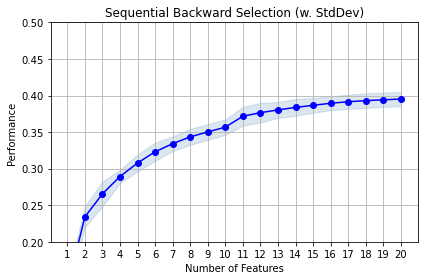

In [26]:
fig1 = plot_sfs(sbs.get_metric_dict(), kind='std_dev')
plt.ylim([0.2, 0.5])
plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.savefig('sffs_linreg.png')
plt.show()

In [10]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

threshold = 20  # the number of most relevant features
#sel_ = SelectFromModel(lr,max_features = threshold)
#sel_ = SelectKBest(score_func=chi2, k = threshold)
#sel_.fit(X_ltr, y_ltr_r)
#selected_feat_lr = X_ltr.columns[(sel_.get_support())]
#from sklearn.feature_selection import mutual_info_classif
#high_score_features = []
#feature_scores = mutual_info_classif(X_ltr, y_ltr_r, random_state=rs)
#for score, f_name in sorted(zip(feature_scores, X_ltr.columns), reverse=True)[:threshold]:
        #print(f_name, score)
        #high_score_features.append(f_name)
#sel_ = RFE(lr, n_features_to_select= 20)
#sel_.fit(X_ltr, y_ltr_r)
#selected_feat_lr = X_ltr.columns[(sel_.get_support())]

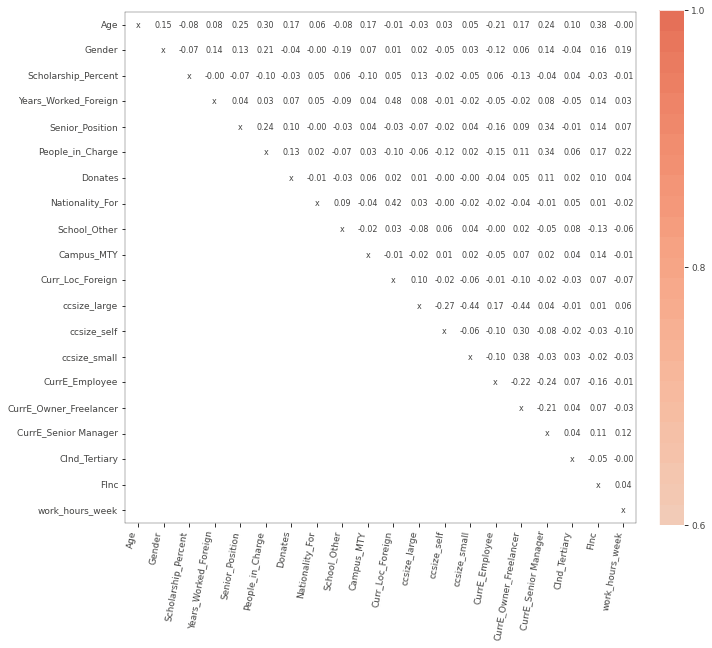

In [27]:
viz = plot_corr_heatmap(X_ltr[selected_feat_lr],figsize=(10,10))

In [8]:
#selected_feat_lr  = ['Gender', 'Years_Worked_Foreign', 'Senior_Position', 'Donates','Nationality_For', 'School_Other', 'Curr_Loc_Foreign','FirstE_Analyst or Assistant', 'FInd_Other', 'FInd_Primary','FInd_Quaternary', 'FInd_Secondary', 'FInd_Tertiary', 'ccsize_large','ccsize_self', 'ccsize_small', 'CurrE_Employee','CurrE_Owner_Freelancer', 'CurrE_Senior Manager', 'CInd_Tertiary']

In [28]:
# Report the before-and-afterscores
est = Ridge(random_state=rs)
print ("\nUnoptimized model:\n------")

# evaluate model
n_scores = cross_val_score(est,X_ltr[selected_feat_lr], y_ltr_r,scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


Unoptimized model:
------
Accuracy score: -36068.244 (398.558)


In [29]:
print ("Best gridsearch parameters\n------")
print (reg_grid_win.best_params_)
# evaluate model
n_scores = cross_val_score(lr,X_ltr[selected_feat_lr], y_ltr_r,scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print ("Best score\n------")
print('Accuracy score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Best gridsearch parameters
------


NameError: name 'reg_grid_win' is not defined

In [11]:
lr_reg =Lasso(random_state=rs, alpha  = 0.001)

### Light Gradient Boosting Tunning

In [16]:
est = LGBMRegressor(random_state = rs)
rfe = RFE(est, n_features_to_select=  20)
rfe.fit(X_ltr, y_ltr_r)
selected_feat_lgb = []
for i in range(X_ltr.shape[1]):
    print('Column: %s, Selected %s, Rank: %.3f' % (X_ltr.columns[i], rfe.support_[i], rfe.ranking_[i]))
    if rfe.support_[i] == True: 
        selected_feat_lgb.append(X_ltr.columns[i])   

Column: Bachelor_GPA, Selected True, Rank: 1.000
Column: Bachelor_Honors, Selected False, Rank: 35.000
Column: Age, Selected True, Rank: 1.000
Column: Gender, Selected False, Rank: 2.000
Column: Scholarship_Percent, Selected True, Rank: 1.000
Column: First_Comp_Size, Selected True, Rank: 1.000
Column: Curr_Comp_Size, Selected True, Rank: 1.000
Column: Country_First_Job, Selected False, Rank: 38.000
Column: Years_Worked_Foreign, Selected True, Rank: 1.000
Column: Senior_Position, Selected False, Rank: 5.000
Column: People_in_Charge, Selected True, Rank: 1.000
Column: Negotiation_Imp, Selected True, Rank: 1.000
Column: TeamWork_Imp, Selected False, Rank: 18.000
Column: Innovation_Imp, Selected True, Rank: 1.000
Column: Communication_Imp, Selected True, Rank: 1.000
Column: Planning_Imp, Selected True, Rank: 1.000
Column: No_Created_Ventures, Selected True, Rank: 1.000
Column: Used_Incubator_program, Selected False, Rank: 50.000
Column: Board_Member, Selected False, Rank: 3.000
Column: Non

In [12]:
selected_feat_lgb = ['Bachelor_GPA',
 'Age',
 'Scholarship_Percent',
 'First_Comp_Size',
 'Curr_Comp_Size',
 'Years_Worked_Foreign',
 'People_in_Charge',
 'Negotiation_Imp',
 'Innovation_Imp',
 'Communication_Imp',
 'Planning_Imp',
 'No_Created_Ventures',
 'Campus_MTY',
 'Curr_Loc_Foreign',
 'MO_Housewive',
 'CurrE_Owner_Freelancer',
 'CurrE_Senior Manager',
 'CInd_Tertiary',
 'FInc',
 'work_hours_week']

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt

>20 33907.006 (446.316)


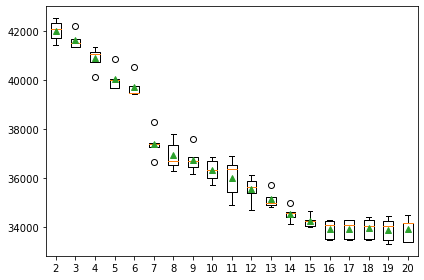

In [49]:
# evaluate the models and store results
models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_ltr, y_ltr_r)
    results.append(scores)
    names.append(name)
print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

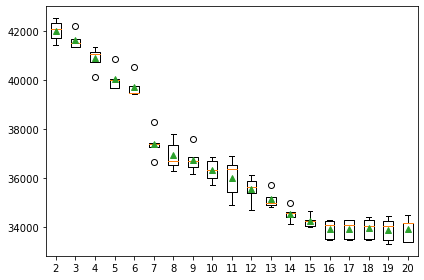

In [50]:
plt.boxplot(results, labels=names, showmeans=True)
plt.savefig('rfe_lgb.png')
plt.show()

In [19]:
selected_feat_lgb = ['Bachelor_GPA',
 'Age',
 'Scholarship_Percent',
 'First_Comp_Size',
 'Curr_Comp_Size',
 'Years_Worked_Foreign',
 'People_in_Charge',
 'Negotiation_Imp',
 'Innovation_Imp',
 'Communication_Imp',
 'Planning_Imp',
 'No_Created_Ventures',
 'Campus_MTY',
 'Curr_Loc_Foreign',
 'MO_Housewive',
 'CurrE_Owner_Freelancer',
 'CurrE_Senior Manager',
 'CInd_Tertiary',
 'FInc',
 'work_hours_week']

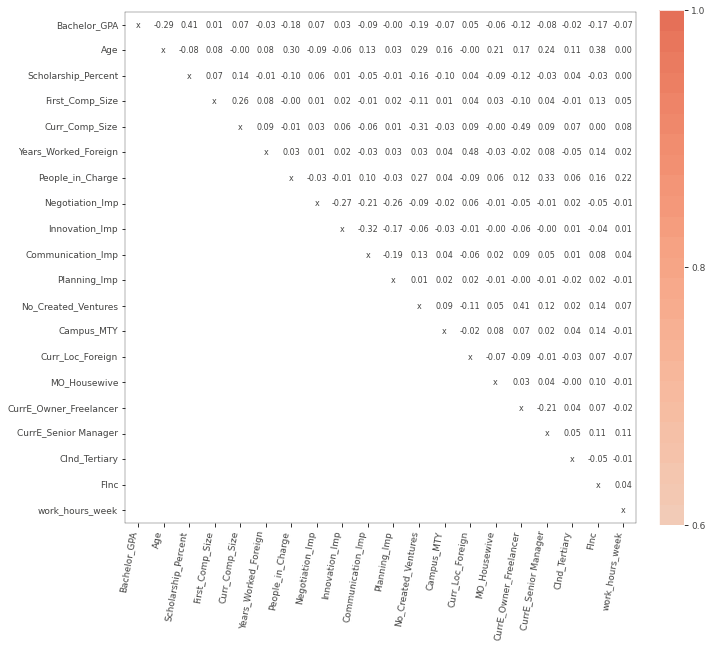

In [20]:
viz = plot_corr_heatmap(X_ltr[selected_feat_lgb],figsize=(10,10))

In [22]:
pipe_lgb = Pipeline(steps=[('s',rfe),('m',est)])
# evaluate model
n_scores = cross_val_score(pipe_lgb, X_ltr, y_ltr_r, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Accuracy: -33773.981 (737.017)


In [ ]:
lgb_grid_search= GridSearchCV(estimator = est, param_grid={'max_depth': [2,4,6,8], 'n_estimators': [10, 100, 500], 'num_leaves': [4,16,32,64] , 'learning_rate':list(np.logspace(np.log(0.005), np.log(0.2),base = np.exp(1), num= 10)) }, n_jobs = -1, cv = cv, scoring = 'neg_mean_absolute_error', error_score=0, verbose = 2)
lgb_grid_win = lgb_grid_search.fit(X_ltr[selected_feat_lgb], y_ltr_r)

Fitting 10 folds for each of 480 candidates, totalling 4800 fits


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 732 tasks      | elapsed:   47.4s
[Parallel(n_jobs=-1)]: Done 1101 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1586 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2153 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2800 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 3529 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 4338 tasks      | elapsed:  5.0min


In [22]:
# Get the estimator
best_clf_lgb = lgb_grid_win.best_estimator_
best_clf_lgb
#results in data frame
lgb_results = pd.DataFrame(lgb_grid_win.cv_results_)
# show the first 5 rows
display(lgb_results.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_num_leaves,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.084457,0.019493,0.011309,0.006066,0.005,2,10,4,"{'learning_rate': 0.005000000000000004, 'max_d...",-49878.721704,...,-48832.485131,-49456.103348,-49173.266567,-48424.850391,-48301.315655,-47511.283176,-48967.134186,-48983.751298,709.400595,477
1,0.081700,0.011439,0.010586,0.007454,0.005,2,10,16,"{'learning_rate': 0.005000000000000004, 'max_d...",-49878.721704,...,-48832.485131,-49456.103348,-49173.266567,-48424.850391,-48301.315655,-47511.283176,-48967.134186,-48983.751298,709.400595,477
2,0.088114,0.013552,0.011454,0.006641,0.005,2,10,32,"{'learning_rate': 0.005000000000000004, 'max_d...",-49878.721704,...,-48832.485131,-49456.103348,-49173.266567,-48424.850391,-48301.315655,-47511.283176,-48967.134186,-48983.751298,709.400595,477
3,0.094489,0.013034,0.017535,0.013426,0.005,2,10,64,"{'learning_rate': 0.005000000000000004, 'max_d...",-49878.721704,...,-48832.485131,-49456.103348,-49173.266567,-48424.850391,-48301.315655,-47511.283176,-48967.134186,-48983.751298,709.400595,477
4,0.270684,0.012823,0.018098,0.005262,0.005,2,100,4,"{'learning_rate': 0.005000000000000004, 'max_d...",-46460.890120,...,-45273.061626,-45460.568055,-45442.665632,-44741.967035,-44930.413722,-44187.634581,-45313.456075,-45350.783832,625.843542,392


In [23]:
lgb_scores = np.array(lgb_results.mean_test_score)
print ("Best gridsearch parameters\n------")
print (lgb_grid_win.best_params_)
print ("----------")
print ("Best score\n------")
print (lgb_grid_win.best_score_)

Best gridsearch parameters
------
{'learning_rate': 0.01134967265153673, 'max_depth': 8, 'n_estimators': 500, 'num_leaves': 64}
----------
Best score
------
-33220.477505051866


In [25]:
# Report the before-and-afterscores
est = LGBMRegressor(random_state=rs)
print ("\nUnoptimized model:\n------")
# evaluate model
n_scores = cross_val_score(est,X_ltr[selected_feat_lgb], y_ltr_r,scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


Unoptimized model:
------
Accuracy score: -33294.355 (771.177)


In [13]:
lgbm_reg = LGBMRegressor(random_state = rs,  max_depth = 8, n_estimators =  500, num_leaves = 64, learning_rate = 0.0113)

In [29]:
print ("Best score\n------")
n_scores = cross_val_score(lgbm_reg,X_ltr[selected_feat_lgb], y_nltr_r,scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Best score
------
Accuracy score: -33240.899 (790.359)


In [30]:
print ("Best score\n------")
n_scores = cross_val_score(lgbm_reg,X_ltr[selected_feat_lgb], y_nltr_r,scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Best score
------
Accuracy score: 0.440 (0.017)


In [46]:
# Save the object in a python file
#import pickle
#with open('tuned_models/binary_lgb_model_win.data','wb') as data:
    #pickle.dump(lgb_grid_win, data)
#with open('tuned_models/binary_lgb_model_grid.data','wb') as data:
    #pickle.dump(lgb_grid_search, data)

## Evaluation

In [14]:
regressors = {}
mae_results = {}
r2_results = {}
r2_adj = {}
rmse = {}
reg_time = {}
regressors['r2'] = r2_results
regressors['r2_adj'] = r2_adj
regressors['rmse'] = rmse
regressors['mae'] = mae_results
regressors['time'] = reg_time
regressors

{'r2': {}, 'r2_adj': {}, 'rmse': {}, 'mae': {}, 'time': {}}

In [15]:
dummy = DummyRegressor( strategy = 'mean')

In [16]:
name = 'Lasso w/Selected Features'
mae_scores, r2_scores, adjusted_r2, rmse_scores ,measured_time,model_name = cross_validation_report_reg(X_ltr[selected_feat_lr],y_ltr_r,lr_reg, model_name = name, scale = True, log_transform = True)
mae_results[name] = mae_scores
r2_adj[name] = adjusted_r2
rmse[name] = rmse_scores
r2_results[name] = r2_scores
reg_time[name] = measured_time

Process Complete in : 0.24390292167663574 sec.
Model: Lasso w/Selected Features
 R2 : 0.3565083864003786
Adjusted R2: 0.3473737615665325
 MAE : 33493.958758273664
RMSE: 54087.89157894498


In [17]:
name = 'Lasso w/All Features'
mae_scores, r2_scores, adjusted_r2, rmse_scores ,measured_time,model_name = cross_validation_report_reg(X_ltr,y_ltr_r,lr_reg, model_name = name, scale = True, log_transform = True)
mae_results[name] = mae_scores
r2_adj[name] = adjusted_r2
rmse[name] = rmse_scores
r2_results[name] = r2_scores
reg_time[name] = measured_time

Process Complete in : 0.8167057037353516 sec.
Model: Lasso w/All Features
 R2 : 0.36424050077701015
Adjusted R2: 0.33099894113058337
 MAE : 33088.07331455448
RMSE: 53759.9244148656


In [18]:
name = 'RF w/Selected Features'
mae_scores, r2_scores, adjusted_r2, rmse_scores ,measured_time,model_name = cross_validation_report_reg(X_ltr[selected_feat_rf],y_ltr_r,rf_reg, model_name = name, scale = False, log_transform = False)
mae_results[name] = mae_scores
r2_adj[name] = adjusted_r2
rmse[name] = rmse_scores
r2_results[name] = r2_scores
reg_time[name] = measured_time

Process Complete in : 426.9530551433563 sec.
Model: RF w/Selected Features
 R2 : 0.415600292961156
Adjusted R2: 0.40730449471958013
 MAE : 34974.17140848703
RMSE: 51559.94552014159


In [19]:
name = 'RF w/All Features'
mae_scores, r2_scores, adjusted_r2, rmse_scores ,measured_time,model_name = cross_validation_report_reg(X_ltr,y_ltr_r,rf_reg, model_name = name, scale = False, log_transform = False)
mae_results[name] = mae_scores
r2_adj[name] = adjusted_r2
rmse[name] = rmse_scores
r2_results[name] = r2_scores
reg_time[name] = measured_time

Process Complete in : 913.505850315094 sec.
Model: RF w/All Features
 R2 : 0.442932132934262
Adjusted R2: 0.41380505130677053
 MAE : 33902.7689730135
RMSE: 50337.64870411352


In [20]:
name = 'LGBM w/Selected Features'
mae_scores, r2_scores, adjusted_r2, rmse_scores ,measured_time,model_name = cross_validation_report_reg(X_ltr[selected_feat_lgb],y_ltr_r,lgbm_reg, model_name = name, scale = False, log_transform = False)
mae_results[name] = mae_scores
r2_adj[name] = adjusted_r2
rmse[name] = rmse_scores
r2_results[name] = r2_scores
reg_time[name] = measured_time

Process Complete in : 11.926627397537231 sec.
Model: LGBM w/Selected Features
 R2 : 0.43110137563253376
Adjusted R2: 0.42302562841647096
 MAE : 34164.26864732125
RMSE: 50863.61234886605


In [21]:
name = 'LGBM w/All Features'
mae_scores, r2_scores, adjusted_r2, rmse_scores ,measured_time,model_name = cross_validation_report_reg(X_ltr,y_ltr_r,lgbm_reg, model_name = name, scale = False, log_transform = False)
mae_results[name] = mae_scores
r2_adj[name] = adjusted_r2
rmse[name] = rmse_scores
r2_results[name] = r2_scores
reg_time[name] = measured_time

Process Complete in : 13.984409093856812 sec.
Model: LGBM w/All Features
 R2 : 0.4687173256009821
Adjusted R2: 0.4409384994361697
 MAE : 32699.235265937205
RMSE: 49153.580745002124


In [22]:
name = 'Dummy Regressor'
mae_scores, r2_scores, adjusted_r2, rmse_scores ,measured_time,model_name = cross_validation_report_reg(X_ltr,y_ltr_r,dummy, model_name = name, scale = False, log_transform = False)
mae_results[name] = mae_scores
r2_adj[name] = adjusted_r2
rmse[name] = rmse_scores
r2_results[name] = r2_scores
reg_time[name] = measured_time

Process Complete in : 0.03637194633483887 sec.
Model: Dummy Regressor
 R2 : -0.0005548417659511529
Adjusted R2: -0.052870472549143344
 MAE : 50544.45587909828
RMSE: 67478.7726448815


## Hold Out Validation

In [23]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, cohen_kappa_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle


In [24]:
predictions = test_validation_reg(lr_reg, X_ltr, y_ltr_r, X_lho,selected_feat_lr)
model_name = 'Lasso validation w/Selected Features'
r2_results[model_name] = metrics.r2_score(y_lho_r,predictions)
mae_results[model_name] = metrics.mean_absolute_error(y_lho_r,predictions)
r2_adj[model_name] = 1 - (1-metrics.r2_score(y_lho_r,predictions))*(len(y_lho_r)-1)/(len(y_lho_r)-X_lho.shape[1]-1)
rmse[model_name] = np.sqrt(metrics.mean_squared_error(y_lho_r,predictions))
print(f'MAE score: {mae_results[model_name]}')
print(f'R2 score: {r2_results[model_name]}')
print(f'R2 adjusted score: {r2_adj[model_name]}')
print(f'RMSE score: {rmse[model_name]}')

MAE score: 38614.330543156335
R2 score: 0.3443964611894811
R2 adjusted score: 0.331108464827635
RMSE score: 55948.52242041726


In [25]:
predictions= test_validation_reg(lr_reg, X_ltr, y_ltr_r, X_lho,False)
model_name = 'Lasso validation w/All Features'
r2_results[model_name] = metrics.r2_score(y_lho_r,predictions)
mae_results[model_name] = metrics.mean_absolute_error(y_lho_r,predictions)
r2_adj[model_name] = 1 - (1-metrics.r2_score(y_lho_r,predictions))*(len(y_lho_r)-1)/(len(y_lho_r)-X_lho.shape[1]-1)
rmse[model_name] = np.sqrt(metrics.mean_squared_error(y_lho_r,predictions))
print(f'MAE score: {mae_results[model_name]}')
print(f'R2 score: {r2_results[model_name]}')
print(f'R2 adjusted score: {r2_adj[model_name]}')
print(f'RMSE score: {rmse[model_name]}')

MAE score: 38641.57304383782
R2 score: 0.3452852662285204
R2 adjusted score: 0.33201528447066275
RMSE score: 55910.58471032168


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1929980671642.207, tolerance: 6513426587.691053
  positive)


In [26]:
predictions= test_validation_reg(rf_reg, X_ltr, y_ltr_r, X_lho,selected_feat_rf)
model_name = 'RF validation w/Selected Features'
r2_results[model_name] = metrics.r2_score(y_lho_r,predictions)
mae_results[model_name] = metrics.mean_absolute_error(y_lho_r,predictions)
r2_adj[model_name] = 1 - (1-metrics.r2_score(y_lho_r,predictions))*(len(y_lho_r)-1)/(len(y_lho_r)-X_lho.shape[1]-1)
rmse[model_name] = np.sqrt(metrics.mean_squared_error(y_lho_r,predictions))
print(f'MAE score: {mae_results[model_name]}')
print(f'R2 score: {r2_results[model_name]}')
print(f'R2 adjusted score: {r2_adj[model_name]}')
print(f'RMSE score: {rmse[model_name]}')

MAE score: 37192.94304324678
R2 score: 0.36884664846184867
R2 adjusted score: 0.35605421684346195
RMSE score: 54895.33292012275


In [27]:
predictions= test_validation_reg(rf_reg, X_ltr, y_ltr_r, X_lho,False)
model_name = 'RF validation w/All Features'
r2_results[model_name] = metrics.r2_score(y_lho_r,predictions)
mae_results[model_name] = metrics.mean_absolute_error(y_lho_r,predictions)
r2_adj[model_name] = 1 - (1-metrics.r2_score(y_lho_r,predictions))*(len(y_lho_r)-1)/(len(y_lho_r)-X_lho.shape[1]-1)
rmse[model_name] = np.sqrt(metrics.mean_squared_error(y_lho_r,predictions))
print(f'MAE score: {mae_results[model_name]}')
print(f'R2 score: {r2_results[model_name]}')
print(f'R2 adjusted score: {r2_adj[model_name]}')
print(f'RMSE score: {rmse[model_name]}')

MAE score: 36038.50745705392
R2 score: 0.3996740541406292
R2 adjusted score: 0.38750644290568337
RMSE score: 53537.92485426032


In [28]:
predictions= test_validation_reg(lgbm_reg, X_ltr, y_ltr_r, X_lho,selected_feat_lgb)
model_name = 'LGB validation w/Selected Features'
r2_results[model_name] = metrics.r2_score(y_lho_r,predictions)
mae_results[model_name] = metrics.mean_absolute_error(y_lho_r,predictions)
r2_adj[model_name] = 1 - (1-metrics.r2_score(y_lho_r,predictions))*(len(y_lho_r)-1)/(len(y_lho_r)-X_lho.shape[1]-1)
rmse[model_name] = np.sqrt(metrics.mean_squared_error(y_lho_r,predictions))
print(f'MAE score: {mae_results[model_name]}')
print(f'R2 score: {r2_results[model_name]}')
print(f'R2 adjusted score: {r2_adj[model_name]}')
print(f'RMSE score: {rmse[model_name]}')

MAE score: 36435.29858114334
R2 score: 0.3885474277823684
R2 adjusted score: 0.37615429828552227
RMSE score: 54031.791203903354


In [29]:
predictions= test_validation_reg(lgbm_reg, X_ltr, y_ltr_r, X_lho,False)
model_name = 'LGB validation w/All Features'
r2_results[model_name] = metrics.r2_score(y_lho_r,predictions)
mae_results[model_name] = metrics.mean_absolute_error(y_lho_r,predictions)
r2_adj[model_name] = 1 - (1-metrics.r2_score(y_lho_r,predictions))*(len(y_lho_r)-1)/(len(y_lho_r)-X_lho.shape[1]-1)
rmse[model_name] = np.sqrt(metrics.mean_squared_error(y_lho_r,predictions))
print(f'MAE score: {mae_results[model_name]}')
print(f'R2 score: {r2_results[model_name]}')
print(f'R2 adjusted score: {r2_adj[model_name]}')
print(f'RMSE score: {rmse[model_name]}')

MAE score: 34928.53646585186
R2 score: 0.4148070703531723
R2 adjusted score: 0.40294618025756146
RMSE score: 52858.82586195606


In [30]:
predictions= test_validation_reg(dummy, X_ltr, y_ltr_r, X_lho,False)
model_name = 'Dummy Classifier validation'
r2_results[model_name] = metrics.r2_score(y_lho_r,predictions)
mae_results[model_name] = metrics.mean_absolute_error(y_lho_r,predictions)
r2_adj[model_name] = 1 - (1-metrics.r2_score(y_lho_r,predictions))*(len(y_lho_r)-1)/(len(y_lho_r)-X_lho.shape[1]-1)
rmse[model_name] = np.sqrt(metrics.mean_squared_error(y_lho_r,predictions))
print(f'MAE score: {mae_results[model_name]}')
print(f'R2 score: {r2_results[model_name]}')
print(f'R2 adjusted score: {r2_adj[model_name]}')
print(f'RMSE score: {rmse[model_name]}')

MAE score: 51647.201167415005
R2 score: -0.0004300787820417096
R2 adjusted score: -0.020707137187272906
RMSE score: 69113.25499820549


## Export Results

In [31]:
reg_df = pd.DataFrame.from_dict(regressors)
reg_df['CV_mean_mae']= 0.0
reg_df['CV_mean_r2'] = 0.0
reg_df['CV_mean_r2_adj'] = 0.0
reg_df['CV_mean_rmse'] = 0.0
reg_df['CV_sd_mae']= 0.0
reg_df['CV_sd_r2'] = 0.0
reg_df['CV_sd_r2_adj'] = 0.0
reg_df['CV_sd_rmse'] = 0.0
others= ['Lasso w/Selected Features',    'Lasso w/All Features',
           'RF w/Selected Features',        'RF w/All Features',
          'LGBM w/Selected Features',        'LGBM w/All Features','Dummy Regressor']
for item in others:
    reg_df.at[item,'CV_mean_mae'] = round(np.mean(reg_df['mae'][item]),4)
    reg_df.at[item,'CV_mean_r2']= round(np.mean(reg_df['r2'][item]),4)
    reg_df.at[item,'CV_mean_r2_adj']= round(np.mean(reg_df['r2_adj'][item]),4)
    reg_df.at[item,'CV_mean_rmse']= round(np.mean(reg_df['rmse'][item]),4)

    
    reg_df.at[item,'CV_sd_mae'] = round(np.std(reg_df['mae'][item]),4)
    reg_df.at[item,'CV_sd_r2'] = round(np.std(reg_df['r2'][item]),4)
    reg_df.at[item,'CV_sd_r2_adj']= round(np.std(reg_df['r2_adj'][item]),4)
    reg_df.at[item,'CV_sd_rmse']= round(np.std(reg_df['rmse'][item]),4)

In [32]:
reg_df

,r2,r2_adj,rmse,mae,time,CV_mean_mae,CV_mean_r2,CV_mean_r2_adj,CV_mean_rmse,CV_sd_mae,CV_sd_r2,CV_sd_r2_adj,CV_sd_rmse
Lasso w/Selected Features,"[0.3983488631472639, 0.2895655096802586, 0.349...","[0.3898087476489994, 0.27948127277011325, 0.34...","[51729.40929575049, 54087.55060937524, 55052.5...","[32639.790738794072, 32793.74694688903, 33118....",0.243903,33493.9588,0.3565,0.3474,54087.8916,1020.3762,0.0352,0.0357,1686.6954
Lasso w/All Features,"[0.4013671189853474, 0.29582774746638985, 0.36...","[0.37006893448458134, 0.2590116724075634, 0.32...","[51599.49273010505, 53848.64131021001, 54507.4...","[32300.018373648098, 32573.20523788955, 32797....",0.816706,33088.0733,0.3642,0.3310,53759.9244,999.1617,0.0350,0.0368,1621.4153
RF w/Selected Features,"[0.42863407357364736, 0.3782288268483992, 0.42...","[0.4205238404093272, 0.369403118216013, 0.4203...","[50410.65229898033, 50600.00822424196, 51596.1...","[34315.681737902145, 33902.995123515866, 34220...",426.953055,34974.1714,0.4156,0.4073,51559.9455,961.3364,0.0211,0.0214,1406.0854
RF w/All Features,"[0.4512446589477894, 0.40553942177808633, 0.45...","[0.4225542103360759, 0.37445937681950314, 0.43...","[49403.137211113266, 49476.25573028094, 50206....","[33465.643998806016, 32980.81518475731, 33223....",913.505850,33902.7690,0.4429,0.4138,50337.6487,908.3282,0.0202,0.0213,1296.7660
LGBM w/Selected Features,"[0.44324164370745844, 0.3834740488704468, 0.44...","[0.4353387571738525, 0.37472279335405856, 0.43...","[49762.07945672123, 50386.12697317607, 50985.4...","[33546.82767496593, 33542.52657379974, 33392.1...",11.926627,34164.2686,0.4311,0.4230,50863.6123,750.7725,0.0219,0.0222,1144.0642
LGBM w/All Features,"[0.468946440384967, 0.4254375796083226, 0.4876...","[0.44118148991908535, 0.39539786543467825, 0.4...","[48599.78079970216, 48641.15786907376, 48854.9...","[32474.90579126919, 32186.27310485225, 31903.6...",13.984409,32699.2353,0.4687,0.4409,49153.5807,823.5763,0.0210,0.0221,1170.3342
Dummy Regressor,"[-0.00020880071234286035, -0.00226440402697170...","[-0.05250248616932085, -0.05466556211674711, -...","[66697.64258149549, 64243.09404189047, 68260.6...","[49912.065208744156, 48155.583644492894, 51064...",0.036372,50544.4559,-0.0006,-0.0529,67478.7726,1086.6877,0.0008,0.0009,1499.3159
Lasso validation w/Selected Features,0.344396,0.331108,55948.5,38614.3,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Lasso validation w/All Features,0.345285,0.332015,55910.6,38641.6,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
RF validation w/Selected Features,0.368847,0.356054,54895.3,37192.9,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [33]:
reg_df.to_csv('class_models/reg_cinc.csv')